# Water Distribution (WADI)

- Source and description: https://itrust.sutd.edu.sg/itrust-labs_datasets/dataset_info/

In [1]:
from typing import List
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

from config import data_raw_folder, data_processed_folder

from timeeval import Datasets, DatasetManager
from timeeval.datasets import DatasetAnalyzer, DatasetRecord

In [2]:
plt.rcParams["figure.figsize"] = (20, 10)

In [3]:
dataset_collection_name = "WADI"
source_folder = Path(data_raw_folder) / "WADI" / "WADI.A2_19 Nov 2019"
target_folder = Path(data_processed_folder)

print(f"Looking for source datasets in {Path(source_folder).absolute()} and\nsaving processed datasets in {Path(target_folder).absolute()}")

Looking for source datasets in /home/projects/akita/data/benchmark-data/data-raw/WADI/WADI.A2_19 Nov 2019 and
saving processed datasets in /home/projects/akita/data/benchmark-data/data-processed


In [4]:
# shared by all datasets
dataset_type = "real"
input_type = "multivariate"
datetime_index = True
split_at = None
train_is_normal = True
train_type = "semi-supervised"

# create target directory
dataset_subfolder = Path(input_type) / dataset_collection_name
target_subfolder = target_folder / dataset_subfolder
target_subfolder.mkdir(parents=True, exist_ok=True)
print(f"Created directories {target_subfolder}")

dm = DatasetManager(target_folder)

Created directories /home/projects/akita/data/benchmark-data/data-processed/multivariate/WADI


In [5]:
def prepare_dataset(df: pd.DataFrame, is_train: bool = False) -> pd.DataFrame:
    # fix index
    df.index = df.index.astype(np.int_) - 1
    df.index.name = df.index.name.strip()

    # fix column names
    df.columns = [c.strip() for c in df.columns]

    # fix timestamps
    s_hour = (18 + (df.index // 3600)) % 24
    s_timestamp = df["Date"] + s_hour.map(" {:02.0f}:".format) + df["Time"]
    s_timestamp = pd.to_datetime(s_timestamp, infer_datetime_format=True)
    df = df.drop(columns=["Date", "Time"])
    df.insert(0, "timestamp", s_timestamp)

    # align anomaly label
    df["is_anomaly"] = 0
    if not is_train:
        s_label = df["Attack LABLE (1:No Attack, -1:Attack)"]
        df = df.drop(columns=["Attack LABLE (1:No Attack, -1:Attack)"])
        df.loc[s_label == -1, "is_anomaly"] = 1
    return df

In [ ]:
print("Processing dataset")
base_dataset_name = "WADI.A2"
test_filename = f"{base_dataset_name}.test.csv"
test_path = dataset_subfolder / test_filename
target_test_filepath = target_subfolder / test_filename

# prepare test dataset
df_test = pd.read_csv(
    source_folder / "WADI_attackdataLABLE.csv",
    skiprows=1,
    skip_blank_lines=True,
    index_col=0
)
df_test = df_test.iloc[:-2, :]
df_test = prepare_dataset(df_test, is_train=False)
df_test.to_csv(target_test_filepath, index=False)
print("  written test dataset")

# prepare train datasets
df_train = pd.read_csv(
    source_folder / "WADI_14days_new.csv",
    skip_blank_lines=True,
    index_col=0
)
df_train = prepare_dataset(df_train, is_train=True)
# split to remove jump
s = df_train["timestamp"].diff()
cut_index = s[s > pd.Timedelta(1, unit="s")].index[0]
dfs_train = []
dfs_train.append(df_train.loc[:cut_index-1])
dfs_train.append(df_train.loc[cut_index:])
print("  loaded train datasets")

# analyze test dataset
da = DatasetAnalyzer((dataset_collection_name, base_dataset_name), is_train=False, df=df_test)
print("  analyzed test dataset")

for i in range(2):
    dataset_name = f"{base_dataset_name}-{i+1}"
    train_filename = f"{dataset_name}.train.csv"
    train_path = dataset_subfolder / train_filename
    target_train_filepath = target_subfolder / train_filename
    target_meta_filepath = target_test_filepath.parent / f"{dataset_name}.{Datasets.METADATA_FILENAME_SUFFIX}"
    
    # overwrite dataset id
    da.dataset_id = (dataset_collection_name, dataset_name)
    meta = da.metadata
    da.save_to_json(target_meta_filepath, overwrite=True)
    print("  written test dataset metadata")
    
    df_train = dfs_train[i]
    df_train.to_csv(target_train_filepath, index=False)
    print(f"  written training dataset {i}")

    DatasetAnalyzer((dataset_collection_name, dataset_name), is_train=True, df=df_train)\
        .save_to_json(target_meta_filepath, overwrite=False)
    print(f"  analyzed training dataset {i}")
    print(f"  written training dataset {i} metadata")

    dm.add_dataset(DatasetRecord(
          collection_name=dataset_collection_name,
          dataset_name=dataset_name,
          train_path=train_path,
          test_path=test_path,
          dataset_type=dataset_type,
          datetime_index=datetime_index,
          split_at=split_at,
          train_type=train_type,
          train_is_normal=train_is_normal,
          input_type=input_type,
          length=meta.length,
          dimensions=meta.dimensions,
          contamination=meta.contamination,
          num_anomalies=meta.num_anomalies,
          min_anomaly_length=meta.anomaly_length.min,
          median_anomaly_length=meta.anomaly_length.median,
          max_anomaly_length=meta.anomaly_length.max,
          mean=meta.mean,
          stddev=meta.stddev,
          trend=meta.trend,
          stationarity=meta.get_stationarity_name(),
          period_size=np.nan
    ))
    print(f"... processed dataset with training file {i+1}")

Processing dataset
  written test dataset
  loaded train datasets


[('WADI', 'WADI.A2') (test)] KPSS trend stationarity test for 1_LS_001_AL encountered an error: cannot convert float NaN to integer
[('WADI', 'WADI.A2') (test)] KPSS trend stationarity test for 1_LS_002_AL encountered an error: cannot convert float NaN to integer
[('WADI', 'WADI.A2') (test)] KPSS trend stationarity test for 1_P_002_STATUS encountered an error: cannot convert float NaN to integer
[('WADI', 'WADI.A2') (test)] KPSS trend stationarity test for 1_P_004_STATUS encountered an error: cannot convert float NaN to integer


In [19]:
dm.save()

In [20]:
dm.refresh()
dm.df().loc[(slice(dataset_collection_name,dataset_collection_name), slice(None))]

train_path  \
collection_name dataset_name                                          
WADI            WADI.A2-1     multivariate/WADI/WADI.A2-1.train.csv   
                WADI.A2-2     multivariate/WADI/WADI.A2-2.train.csv   

                                                       test_path dataset_type  \
collection_name dataset_name                                                    
WADI            WADI.A2-1     multivariate/WADI/WADI.A2.test.csv         real   
                WADI.A2-2     multivariate/WADI/WADI.A2.test.csv         real   

                              datetime_index  split_at       train_type  \
collection_name dataset_name                                              
WADI            WADI.A2-1               True       NaN  semi-supervised   
                WADI.A2-2               True       NaN  semi-supervised   

                              train_is_normal    input_type  length  \
collection_name dataset_name                                          
WADI            WADI.A2-1                True  multivariate  172801   
                WADI.A2-2                True  multivariate  172801   

                              dimensions  contamination  num_anomalies  \
collection_name dataset_name                                             
WADI            WADI.A2-1            127       0.057737             14   
                WADI.A2-2            127       0.057737             14   

                              min_anomaly_length  median_anomaly_length  \
collection_name dataset_name                                              
WADI            WADI.A2-1                     88                    651   
                WADI.A2-2                     88                    651   

                              max_anomaly_length  mean  stddev        trend  \
collection_name dataset_name                                                  
WADI            WADI.A2-1                   1741   NaN     NaN  kubic trend   
                WADI.A2-2                   1741   NaN     NaN  kubic trend   

                                stationarity  period_size  
collection_name dataset_name                               
WADI            WADI.A2-1     not_stationary          NaN  
                WADI.A2-2     not_stationary          NaN

## Exploration

In [6]:
df = pd.read_csv(source_folder / "WADI_attackdataLABLE.csv",
                 skiprows=1,
                 skip_blank_lines=True,
                 index_col=0).iloc[:-2, :]
# fix index
df.index = df.index.astype(np.int_) - 1
df.index.name = df.index.name.strip()

# fix column names
df.columns = [c.strip() for c in df.columns]

# fix timestamps
s_hour = (18 + (df.index // 3600)) % 24
s_timestamp = df["Date"] + s_hour.map(" {:02.0f}:".format) + df["Time"]
s_timestamp = pd.to_datetime(s_timestamp, infer_datetime_format=True)
df = df.drop(columns=["Date", "Time"])
df.insert(0, "timestamp", s_timestamp)

# align anomaly label
s_label = df["Attack LABLE (1:No Attack, -1:Attack)"]
df = df.drop(columns=["Attack LABLE (1:No Attack, -1:Attack)"])
df["is_anomaly"] = 0
df.loc[s_label == -1, "is_anomaly"] = 1

df

,timestamp,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,is_anomaly
Row,,,,,,,,,,,,,,,,,,,,,
0,2017-10-09 18:00:00,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
1,2017-10-09 18:00:01,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
2,2017-10-09 18:00:02,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
3,2017-10-09 18:00:03,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
4,2017-10-09 18:00:04,164.210,0.529486,11.9972,482.480,0.331167,0.001273,0.0,0.0,48.4820,...,1.0,1.0,1.0,1.0,1.0,1.0,62.6226,1.0,0.39,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172796,2017-10-11 17:59:56,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,...,1.0,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.00,0
172797,2017-10-11 17:59:57,172.959,0.547483,11.9184,466.034,0.318217,0.001222,0.0,0.0,55.5587,...,1.0,1.0,1.0,1.0,1.0,1.0,59.3546,1.0,0.00,0
172798,2017-10-11 17:59:58,172.915,0.583479,11.9211,466.051,0.318317,0.001260,0.0,0.0,55.7260,...,1.0,1.0,1.0,1.0,1.0,1.0,58.8102,1.0,0.00,0


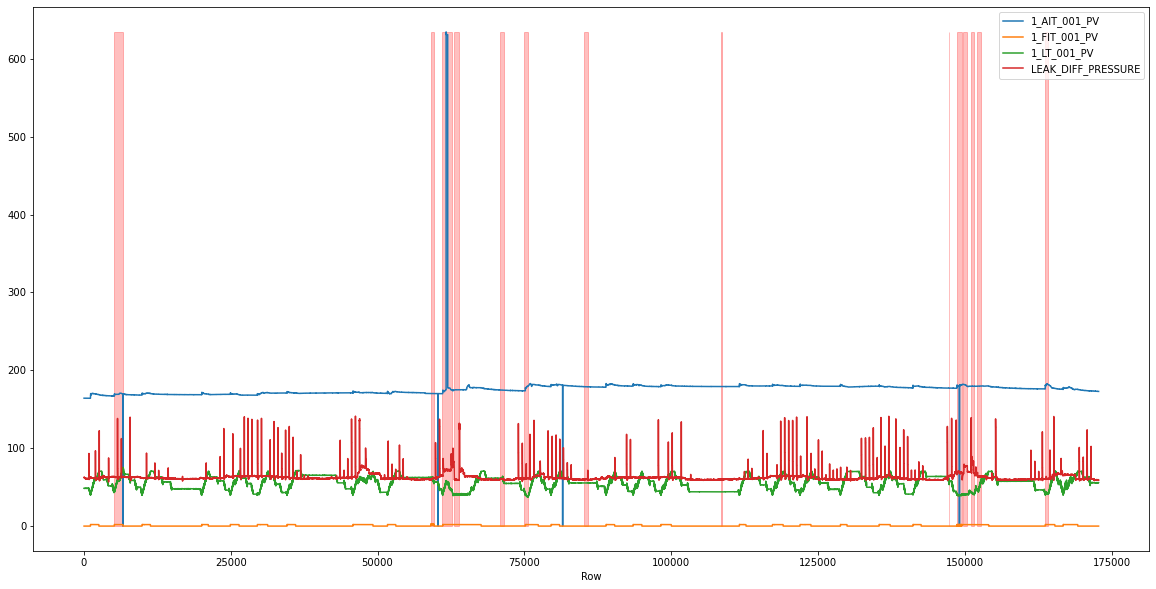

In [7]:
df_tmp = df[["1_AIT_001_PV", "1_FIT_001_PV", "1_LT_001_PV", "LEAK_DIFF_PRESSURE", "is_anomaly"]]
df_tmp.iloc[:, :-1].plot()
s = df_tmp["is_anomaly"].diff()
for begin, end in zip(s[s == -1].index, s[s == 1].index):
    plt.gca().add_patch(matplotlib.patches.Rectangle((begin, 0), end - begin, df_tmp.max().max(), color="red", alpha=0.25))
plt.show()

In [8]:
df2 = pd.read_csv(source_folder / "WADI_14days_new.csv",
                 skip_blank_lines=True,
                 index_col=0)
# fix index
df2.index = df2.index.astype(np.int_) - 1
df2.index.name = df2.index.name.strip()

# fix column names
df2.columns = [c.strip() for c in df2.columns]

# fix timestamps
s_hour = (18 + (df2.index // 3600)) % 24
s_timestamp = df2["Date"] + s_hour.map(" {:02.0f}:".format) + df2["Time"]
s_timestamp = pd.to_datetime(s_timestamp, infer_datetime_format=True)
df2 = df2.drop(columns=["Date", "Time"])
df2.insert(0, "timestamp", s_timestamp)

# insert anomaly label
df2["is_anomaly"] = 0

df2

,timestamp,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,is_anomaly
Row,,,,,,,,,,,,,,,,,,,,,
0,2017-09-25 18:00:00,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,...,1,1,1,1,1,1,67.9651,1,0.68,0
1,2017-09-25 18:00:01,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,...,1,1,1,1,1,1,67.9651,1,0.68,0
2,2017-09-25 18:00:02,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,...,1,1,1,1,1,1,67.9651,1,0.68,0
3,2017-09-25 18:00:03,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,...,1,1,1,1,1,1,67.1948,1,0.68,0
4,2017-09-25 18:00:04,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,...,1,1,1,1,1,1,67.1948,1,0.68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048566,2017-10-07 21:16:06,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,...,1,1,1,1,1,1,60.6305,1,0.25,0
1048567,2017-10-07 21:16:07,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,...,1,1,1,1,1,1,60.6305,1,0.25,0
1048568,2017-10-07 21:16:08,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,...,1,1,1,1,1,1,60.6305,1,0.25,0


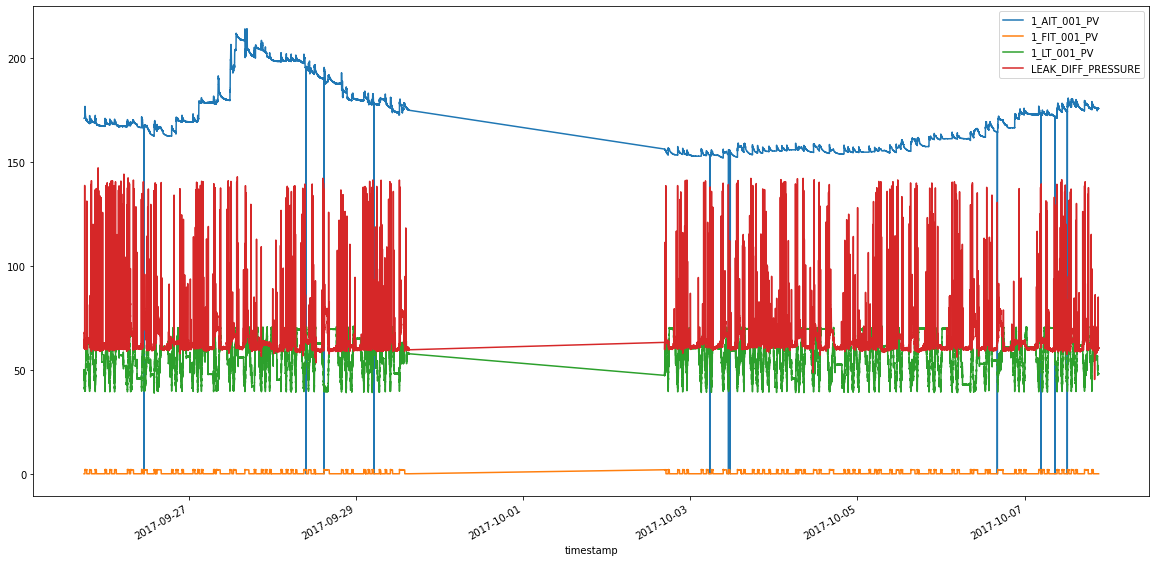

In [9]:
df_tmp = df2.set_index("timestamp")
df_tmp = df_tmp[["1_AIT_001_PV", "1_FIT_001_PV", "1_LT_001_PV", "LEAK_DIFF_PRESSURE"]]#.iloc[330000:340000]
df_tmp.plot()
plt.show()

It seems that the authors just removed the parts of the time series, where there were instabilities in the system.
We decide to cut the time series in two parts (the instabilities were roughly in the middle of the experiment) and use each as a separate training dataset.

Cut point after 2017-09-29 15:19:58, because of the jump from row index 335998 to 599999:

In [10]:
s = df2["timestamp"].diff()
s = s[s > pd.Timedelta(1, unit="s")]
cut_index = s.index[0]
s

Row
599999   3 days 01:20:01
Name: timestamp, dtype: timedelta64[ns]

In [11]:
df2.loc[335995:600002]

,timestamp,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,is_anomaly
Row,,,,,,,,,,,,,,,,,,,,,
335995,2017-09-29 15:19:55,175.080,0.565481,11.6779,510.257,0.338041,0.001127,0,0,57.8136,...,1,1,1,1,1,1,59.5862,1,0.00,0
335996,2017-09-29 15:19:56,175.080,0.565481,11.6779,510.257,0.338041,0.001127,0,0,57.8136,...,1,1,1,1,1,1,59.5862,1,0.00,0
335997,2017-09-29 15:19:57,175.025,0.553482,11.6739,510.257,0.338080,0.001244,0,0,57.7764,...,1,1,1,1,1,1,59.6988,1,0.00,0
335998,2017-09-29 15:19:58,175.025,0.553482,11.6739,510.257,0.338080,0.001244,0,0,57.7764,...,1,1,1,1,1,1,59.6988,1,0.00,0
599999,2017-10-02 16:39:59,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600000,2017-10-02 16:40:00,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600001,2017-10-02 16:40:01,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600002,2017-10-02 16:40:02,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0


In [12]:
df2.loc[:cut_index-1]

,timestamp,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,is_anomaly
Row,,,,,,,,,,,,,,,,,,,,,
0,2017-09-25 18:00:00,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,...,1,1,1,1,1,1,67.9651,1,0.68,0
1,2017-09-25 18:00:01,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,...,1,1,1,1,1,1,67.9651,1,0.68,0
2,2017-09-25 18:00:02,171.155,0.619473,11.5759,504.645,0.318319,0.001157,0,0,47.8911,...,1,1,1,1,1,1,67.9651,1,0.68,0
3,2017-09-25 18:00:03,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,...,1,1,1,1,1,1,67.1948,1,0.68,0
4,2017-09-25 18:00:04,171.155,0.607477,11.5725,504.673,0.318438,0.001207,0,0,47.7503,...,1,1,1,1,1,1,67.1948,1,0.68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335994,2017-09-29 15:19:54,175.080,0.565481,11.6779,510.257,0.338041,0.001127,0,0,57.8136,...,1,1,1,1,1,1,59.5862,1,0.00,0
335995,2017-09-29 15:19:55,175.080,0.565481,11.6779,510.257,0.338041,0.001127,0,0,57.8136,...,1,1,1,1,1,1,59.5862,1,0.00,0
335996,2017-09-29 15:19:56,175.080,0.565481,11.6779,510.257,0.338041,0.001127,0,0,57.8136,...,1,1,1,1,1,1,59.5862,1,0.00,0


In [13]:
df2.loc[cut_index:]

,timestamp,1_AIT_001_PV,1_AIT_002_PV,1_AIT_003_PV,1_AIT_004_PV,1_AIT_005_PV,1_FIT_001_PV,1_LS_001_AL,1_LS_002_AL,1_LT_001_PV,...,3_MV_002_STATUS,3_MV_003_STATUS,3_P_001_STATUS,3_P_002_STATUS,3_P_003_STATUS,3_P_004_STATUS,LEAK_DIFF_PRESSURE,PLANT_START_STOP_LOG,TOTAL_CONS_REQUIRED_FLOW,is_anomaly
Row,,,,,,,,,,,,,,,,,,,,,
599999,2017-10-02 16:39:59,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600000,2017-10-02 16:40:00,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600001,2017-10-02 16:40:01,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600002,2017-10-02 16:40:02,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
600003,2017-10-02 16:40:03,156.378,0.691463,11.8310,480.409,0.260597,1.898500,0,0,47.4149,...,1,1,1,1,1,1,63.2665,1,1.14,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048566,2017-10-07 21:16:06,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,...,1,1,1,1,1,1,60.6305,1,0.25,0
1048567,2017-10-07 21:16:07,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,...,1,1,1,1,1,1,60.6305,1,0.25,0
1048568,2017-10-07 21:16:08,175.855,0.589478,11.8941,479.191,0.331571,0.001128,0,0,48.1129,...,1,1,1,1,1,1,60.6305,1,0.25,0
